В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
raw_df = pd.read_csv("/content/drive/MyDrive/Machine_Learning/datasets/module_02_02/bank-customer-churn-prediction-dlu-course-c-3/train.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any


def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [3]:
train_df, val_df = split_train_val(raw_df, target_col='Exited')
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7180,7180,15652218.0,Mays,682.0,France,Male,30.0,1.0,131394.56,1.0,1.0,1.0,143952.24,0.0
10393,10393,15592937.0,Ch'eng,684.0,France,Female,39.0,2.0,178058.06,1.0,1.0,0.0,145518.31,0.0
80,80,15774586.0,Ch'in,705.0,Germany,Male,35.0,6.0,116320.68,2.0,1.0,0.0,174431.01,0.0
3365,3365,15780572.0,K?,669.0,Spain,Male,58.0,0.0,0.00,2.0,0.0,1.0,51565.98,0.0
12236,12236,15642099.0,Trevisani,707.0,France,Male,21.0,3.0,0.00,2.0,1.0,1.0,148564.76,0.0


In [4]:
val_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6490,6490,15794345.0,Pirozzi,714.0,Germany,Male,46.0,1.0,115764.32,4.0,1.0,1.0,72945.32,1.0
3646,3646,15617348.0,Ritchie,593.0,France,Male,41.0,5.0,0.00,2.0,1.0,1.0,38196.24,0.0
5306,5306,15787907.0,Hs?eh,731.0,France,Female,38.0,2.0,0.00,2.0,0.0,1.0,116971.05,0.0
652,652,15803378.0,Onio,673.0,France,Female,43.0,4.0,155739.76,1.0,0.0,1.0,111622.76,0.0
2627,2627,15772423.0,Genovesi,678.0,Spain,Female,30.0,4.0,0.00,2.0,1.0,0.0,143681.85,0.0


In [5]:
input_cols = list(train_df.columns)[0:-1]
target_col = 'Exited'

X_train, train_targets = separate_inputs_targets(train_df, input_cols=input_cols, target_col=target_col)
X_val, val_targets = separate_inputs_targets(val_df, input_cols=input_cols, target_col=target_col)

X_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
7180,7180,15652218.0,Mays,682.0,France,Male,30.0,1.0,131394.56,1.0,1.0,1.0,143952.24
10393,10393,15592937.0,Ch'eng,684.0,France,Female,39.0,2.0,178058.06,1.0,1.0,0.0,145518.31
80,80,15774586.0,Ch'in,705.0,Germany,Male,35.0,6.0,116320.68,2.0,1.0,0.0,174431.01
3365,3365,15780572.0,K?,669.0,Spain,Male,58.0,0.0,0.00,2.0,0.0,1.0,51565.98
12236,12236,15642099.0,Trevisani,707.0,France,Male,21.0,3.0,0.00,2.0,1.0,1.0,148564.76


In [6]:
train_targets.head()

,Exited
7180,0.0
10393,0.0
80,0.0
3365,0.0
12236,0.0


In [7]:
X_val.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
6490,6490,15794345.0,Pirozzi,714.0,Germany,Male,46.0,1.0,115764.32,4.0,1.0,1.0,72945.32
3646,3646,15617348.0,Ritchie,593.0,France,Male,41.0,5.0,0.00,2.0,1.0,1.0,38196.24
5306,5306,15787907.0,Hs?eh,731.0,France,Female,38.0,2.0,0.00,2.0,0.0,1.0,116971.05
652,652,15803378.0,Onio,673.0,France,Female,43.0,4.0,155739.76,1.0,0.0,1.0,111622.76
2627,2627,15772423.0,Genovesi,678.0,Spain,Female,30.0,4.0,0.00,2.0,1.0,0.0,143681.85


In [8]:
val_targets.head()

,Exited
6490,1.0
3646,0.0
5306,0.0
652,0.0
2627,0.0


1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [9]:
cat_features = X_train.select_dtypes(include='object').columns
X_train[cat_features] = X_train[cat_features].astype('category')
X_val[cat_features] = X_val[cat_features].astype('category')
X_train.dtypes

,0
id,int64
CustomerId,float64
Surname,category
CreditScore,float64
Geography,category
Gender,category
Age,float64
Tenure,float64
Balance,float64
NumOfProducts,float64


2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

xgb_clf = XGBClassifier(
    max_depth=6,
    n_estimators=10,
    enable_categorical=True,
    use_label_encoder=False,
    missing=np.nan,
    device='cuda'
)

xgb_clf.fit(X_train, train_targets)

train_pred = xgb_clf.predict(X_train)
val_pred = xgb_clf.predict(X_val)

y_pred_proba_train = xgb_clf.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, thresholds_train = roc_curve(train_targets, y_pred_proba_train, pos_label=1.0)
auroc_train = auc(fpr_train, tpr_train)
print(f'AUROC_train: {auroc_train:.2f}')
y_pred_proba_val = xgb_clf.predict_proba(X_val)[:, 1]
fpr_val, tpr_val, thresholds_val = roc_curve(val_targets, y_pred_proba_val, pos_label=1.0)
auroc_val = auc(fpr_val, tpr_val)
print(f'AUROC_valiation: {auroc_val:.2f}')

AUROC_train: 0.97
AUROC_valiation: 0.93


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:01] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


В цілому модель хорошої якості, на валідаційних даних показує вищий AUROC ніж з використанням DecisionTrees (0.93 і 0.92, відповідно). Проте, помітна різниця в AUROC на тренувальних і валідаційних даних (0.97 і 0.93), що може свідчити про high variance. Попри те, що ця різниця не є надто великою, модель бажано покращити

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [11]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
def objective(params):
    clf = xgb.XGBClassifier(
    n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        gamma=params['gamma'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        enable_categorical=True,
        use_label_encoder=False,
        missing=np.nan,
        device='cuda',
        early_stopping_rounds=20
    )

    clf.fit(
        X_train,
        train_targets,
        eval_set=[(X_val, val_targets)],
        verbose=False)
    y_pred_proba = clf.predict_proba(X_val)[:, 1]
    fpr, tpr, thresholds = roc_curve(val_targets, y_pred_proba, pos_label=1.0)
    auroc = auc(fpr, tpr)
    return {'loss': -auroc, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 25),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.5),
    'max_depth': hp.quniform('max_depth', 3, 30, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = xgb.XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    use_label_encoder=False,
    missing=np.nan,
    device='cuda',
)

final_clf.fit(X_train, train_targets)
train_pred_final = final_clf.predict(X_train)
val_pred_final = final_clf.predict(X_val)

y_pred_proba_train_final = final_clf.predict_proba(X_train)[:, 1]
fpr_train_final, tpr_train_final, thresholds_train_final = roc_curve(train_targets, y_pred_proba_train_final, pos_label=1.0)
auroc_train_final = auc(fpr_train, tpr_train)
print(f'AUROC_train_final: {auroc_train_final:.2f}')
y_pred_proba_val_final = final_clf.predict_proba(X_val)[:, 1]
fpr_val_final, tpr_val_final, thresholds_val_final = roc_curve(val_targets, y_pred_proba_val_final, pos_label=1.0)
auroc_val_final = auc(fpr_val_final, tpr_val_final)
print(f'AUROC_valiation_final: {auroc_val_final:.2f}')

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  5%|▌         | 1/20 [00:00<00:07,  2.60trial/s, best loss: -0.9325728787982714]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 10%|█         | 2/20 [00:01<00:14,  1.27trial/s, best loss: -0.9325728787982714]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 15%|█▌        | 3/20 [00:02<00:18,  1.10s/trial, best loss: -0.9325728787982714]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 20%|██        | 4/20 [00:04<00:22,  1.40s/trial, best loss: -0.9325728787982714]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 25%|██▌       | 5/20 [00:05<00:15,  1.07s/trial, best loss: -0.9325728787982714]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 30%|███       | 6/20 [00:05<00:11,  1.25trial/s, best loss: -0.9325728787982714]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 40%|████      | 8/20 [00:06<00:06,  1.98trial/s, best loss: -0.9325728787982714]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 45%|████▌     | 9/20 [00:06<00:04,  2.34trial/s, best loss: -0.9325783661430824]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 50%|█████     | 10/20 [00:06<00:03,  2.62trial/s, best loss: -0.9325783661430824]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 55%|█████▌    | 11/20 [00:08<00:07,  1.14trial/s, best loss: -0.9352280677687085]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 65%|██████▌   | 13/20 [00:09<00:03,  1.78trial/s, best loss: -0.9352280677687085]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 70%|███████   | 14/20 [00:09<00:03,  1.71trial/s, best loss: -0.9352280677687085]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 75%|███████▌  | 15/20 [00:11<00:04,  1.20trial/s, best loss: -0.9352280677687085]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 80%|████████  | 16/20 [00:11<00:02,  1.44trial/s, best loss: -0.9352280677687085]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 85%|████████▌ | 17/20 [00:12<00:02,  1.24trial/s, best loss: -0.9352280677687085]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 95%|█████████▌| 19/20 [00:13<00:00,  1.81trial/s, best loss: -0.9352280677687085]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



100%|██████████| 20/20 [00:13<00:00,  1.47trial/s, best loss: -0.9352280677687085]
Найкращі гіперпараметри:  {'colsample_bytree': np.float64(0.9300532124014341), 'gamma': np.float64(0.3742305095368459), 'learning_rate': np.float64(0.018303853400172713), 'max_depth': 25, 'min_child_weight': 6, 'n_estimators': 325, 'reg_alpha': np.float64(0.9678202315628142), 'reg_lambda': np.float64(0.9970341767965836), 'subsample': np.float64(0.5780902396342846)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AUROC_train_final: 0.97
AUROC_valiation_final: 0.93


Модель показує такий самий результат, як в завданні 2: auroc 0.97 на тренувальних даних і 0.93 на валідаційних

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [12]:
import lightgbm as lgb
print(lgb.__version__)

4.5.0


In [13]:
cat_feature_indexes = [X_train.columns.get_loc(col) for col in cat_features]
lgb_clf = lgb.LGBMClassifier(
    max_depth=6,
    n_estimators=100,
    learning_rate=0.05,
    cat_feature=cat_feature_indexes,
    missing=np.nan
)

lgb_clf.fit(X_train, train_targets, eval_set=[(X_val, val_targets)])
y_pred_proba_train = lgb_clf.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, thresholds_train = roc_curve(train_targets, y_pred_proba_train, pos_label=1.0)
auroc_train = auc(fpr_train, tpr_train)
print(f'AUROC_train: {auroc_train:.2f}')
y_pred_proba_val = lgb_clf.predict_proba(X_val)[:, 1]
fpr_val, tpr_val, thresholds_val = roc_curve(val_targets, y_pred_proba_val, pos_label=1.0)
auroc_val = auc(fpr_val, tpr_val)
print(f'AUROC_valiation: {auroc_val:.2f}')

[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set with cat_feature=2,4,5, categorical_column=2,4,5 will be ignored. Current value: categorical_feature=2,4,5
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1826
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 13
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]: pavg=

Модель показує такий самий результат, як XGBoost: auroc 0.97 на тренувальних даних і 0.93 на валідаційних

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [14]:
def objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),  # Кількість дерев у ансамблі (кількість ітерацій бустингу)
        learning_rate=params['learning_rate'],  # Коефіцієнт, на який зменшується внесок кожного доданого дерева
        max_depth=int(params['max_depth']),  # Максимальна глибина кожного дерева
        num_leaves=int(params['num_leaves']),  # Максимальна кількість листків, що дозволяємо кожному дереву мати.
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        min_split_gain=params['min_split_gain'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        cat_feature=cat_feature_indexes  # Індекси категорійних ознак
    )

    clf.fit(X_train, train_targets, eval_set=[(X_val, val_targets)])
    y_pred_proba = clf.predict_proba(X_val)[:, 1]
    fpr, tpr, thresholds = roc_curve(val_targets, y_pred_proba, pos_label=1.0)
    auroc = auc(fpr, tpr)
    return {'loss': -auroc, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'max_depth': hp.quniform('max_depth', 3, 50, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)  # додано мінімальне зменшення втрат для поділу
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = lgb.LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    cat_feature=cat_feature_indexes,
    missing=np.nan
)

final_clf.fit(X_train, train_targets, eval_set=[(X_val, val_targets)])
train_pred_final = final_clf.predict(X_train)
val_pred_final = final_clf.predict(X_val)

y_pred_proba_train_final = final_clf.predict_proba(X_train)[:, 1]
fpr_train_final, tpr_train_final, thresholds_train_final = roc_curve(train_targets, y_pred_proba_train_final, pos_label=1.0)
auroc_train_final = auc(fpr_train, tpr_train)
print(f'AUROC_train_final: {auroc_train_final:.2f}')
y_pred_proba_val_final = final_clf.predict_proba(X_val)[:, 1]
fpr_val_final, tpr_val_final, thresholds_val_final = roc_curve(val_targets, y_pred_proba_val_final, pos_label=1.0)
auroc_val_final = auc(fpr_val_final, tpr_val_final)
print(f'AUROC_validation_final: {auroc_val_final:.2f}')

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

Модель показує такий самий результат, як і без бібліотеки `Hyperopt`: auroc 0.97 на тренувальних даних і 0.93 на валідаційних

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

In [16]:
test_df = pd.read_csv("/content/drive/MyDrive/Machine_Learning/datasets/module_02_02/bank-customer-churn-prediction-dlu-course-c-3/test.csv")
test_df[cat_features] = test_df[cat_features].astype('category')
test_df['Exited'] = xgb_clf.predict(test_df)
test_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,0
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,0
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,0
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0


In [17]:
submission = pd.read_csv("/content/drive/MyDrive/Machine_Learning/datasets/module_02_02/bank-customer-churn-prediction-dlu-course-c-3/sample_submission.csv")
submission.head()

,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5


In [18]:
submission['Exited'] = submission['id'].map(test_df.set_index('id')['Exited'])
submission.reset_index(drop=True, inplace=True)
submission.head()

,id,Exited
0,15000,0
1,15001,0
2,15002,0
3,15003,0
4,15004,0


In [19]:
submission.to_csv("/content/drive/MyDrive/Machine_Learning/datasets/module_02_02/bank-customer-churn-prediction-dlu-course-c-3/submission_xgb.csv", index=False)

Оскільки всі моделі показують однковий AUROC, вибрав найпершу - XGBoost, без тюнінгу параметрів

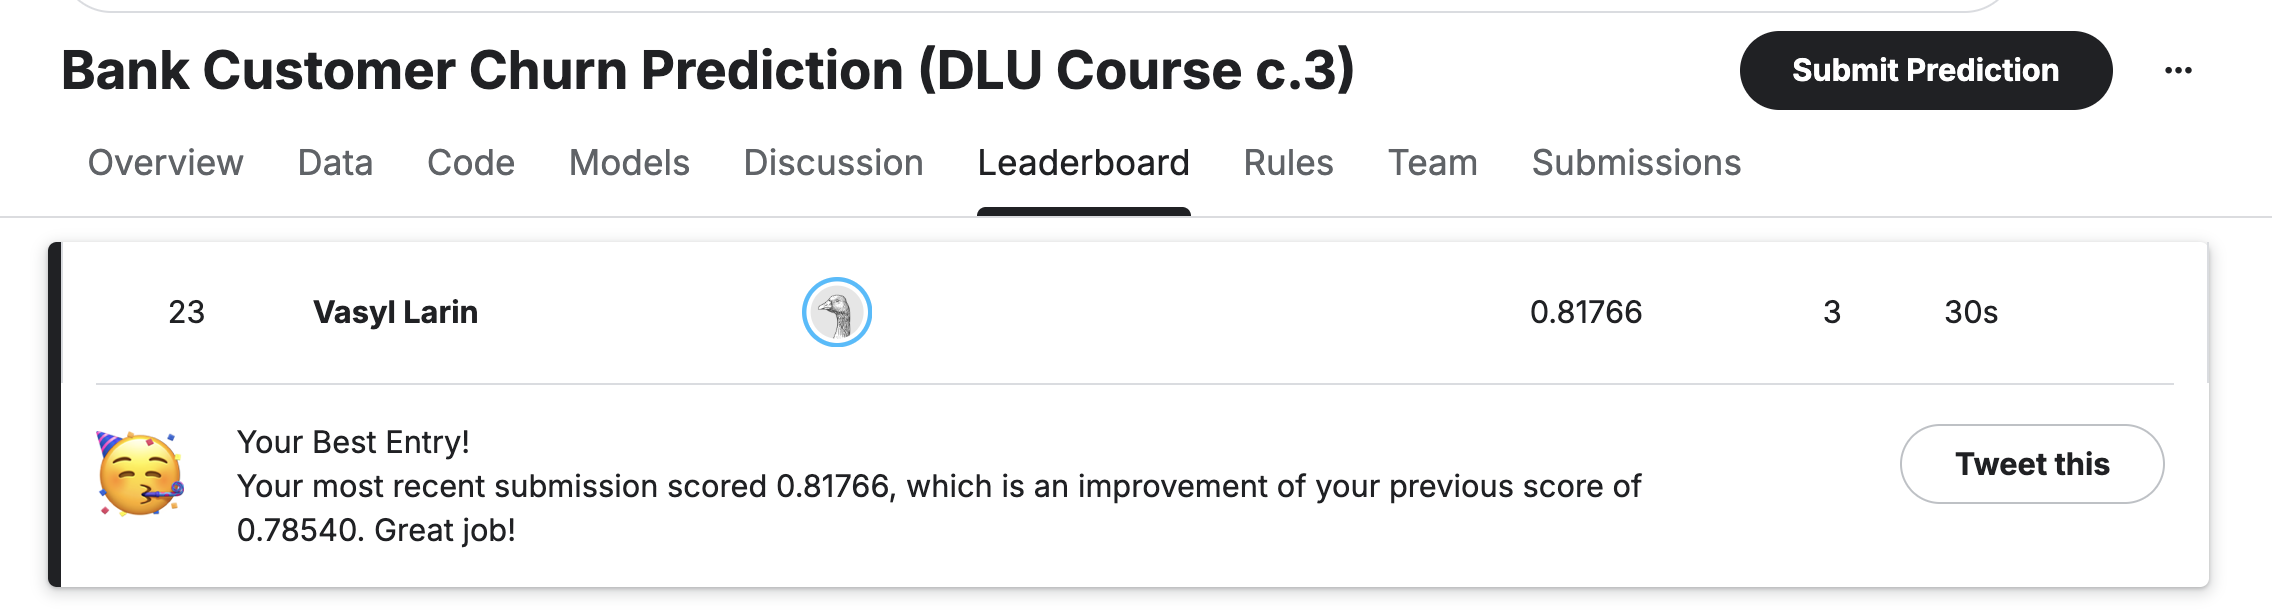

In [20]:
from IPython.display import Image
Image('/content/drive/MyDrive/Machine_Learning/datasets/module_02_02/bank-customer-churn-prediction-dlu-course-c-3/Kaggle v2025-07-15.png')